# Pre-encoding a dataset for DALLE·mini

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   24G   55G  31% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.1G  841M  58% /usr/sbin/docker-init
/dev/sda1        80G   49G   31G  62% /opt/bin/.nvidia
tmpfs           6.4G   32K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
!cat /proc/meminfo

MemTotal:       13297200 kB
MemFree:         9353128 kB
MemAvailable:   12416004 kB
Buffers:          338864 kB
Cached:          2902192 kB
SwapCached:            0 kB
Active:           587564 kB
Inactive:        3100860 kB
Active(anon):        952 kB
Inactive(anon):   439568 kB
Active(file):     586612 kB
Inactive(file):  2661292 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:             11392 kB
Writeback:             0 kB
AnonPages:        447564 kB
Mapped:           232076 kB
Shmem:              1296 kB
KReclaimable:     112848 kB
Slab:             143800 kB
SReclaimable:     112848 kB
SUnreclaim:        30952 kB
KernelStack:        4128 kB
PageTables:         7656 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648600 kB
Committed_AS:    2354872 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       49944 kB
VmallocChunk:          0 kB
Percpu:          

This notebook shows how to pre-encode images to token sequences using JAX, VQGAN and a dataset in the [`webdataset` format](https://webdataset.github.io/webdataset/).

Adapt it to your own dataset and image encoder.

At the end you should have a dataset of pairs:
* a caption defined as a string
* an encoded image defined as a list of int.

In [ ]:
!pip install transformers
!pip install einops
!pip install unidecode
!pip install ftfy
!pip install emoji
!pip install pillow
!pip install jax
!pip install flax
# !pip install flax==0.3.5
!pip install wandb
!pip install tqdm
!pip install optax
!pip install braceexpand
!pip install datasets[streaming]
!pip install black[jupyter]
!pip install isort
!pip install webdataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 18.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install braceexpand
import braceexpand

datasets = "{000..29999}.parquet"

In [ ]:
for i in range(19999):
  !cp -r '/content/drive/'

In [ ]:
from tqdm.notebook import tqdm

import torchvision.transforms as T

import webdataset as wds

import jax
import braceexpand
from pathlib import Path

## Configuration Parameters

In [ ]:
shards = "/content/drive/MyDrive/Colab Notebooks/dataset/CelebA-HQ.tar"  # defined using braceexpand format as used by webdataset
encoded_output = Path("/content/drive/MyDrive/Colab Notebooks/dataset/yolo")  # where we will save our encoded data

VQGAN_REPO, VQGAN_COMMIT_ID = (
    "dalle-mini/vqgan_imagenet_f16_16384",
    "85eb5d3b51a1c62a0cc8f4ccdee9882c0d0bd384",
)
# VQGAN_REPO = 'flax-community/vqgan_f16_16384'
# VQGAN_COMMIT_ID = '90cc46addd2dd8f5be21586a9a23e1b95aa506a9'
# good defaults for a TPU v3-8
batch_size = 1  # Per device
num_workers = 1  # For parallel processing
total_bs = batch_size * jax.device_count()  # You can use a smaller size while testing
save_frequency = 1  # Number of batches to create a new file (180MB for f16 and 720MB for f8 per file)

In [ ]:
shards = list(
    braceexpand.braceexpand(shards)
)  # better display for tqdm with known length

## Load data

We load data using `webdataset`.

In [ ]:
ds = (
    wds.WebDataset(shards, handler=wds.warn_and_continue)
    .decode("rgb", handler=wds.warn_and_continue)
    .to_tuple("jpg", "txt")  # assumes image is in `jpg` and caption in `txt`
    .batched(total_bs)  # load in batch per worker (faster)
)

Note:
* you can also shuffle shards and items using `shardshuffle` and `shuffle` if necessary.
* you may need to resize images in your pipeline (with `map_dict` for example), we assume they are already set to 256x256.
* you can also filter out some items using `select`.

We can now inspect our data.

In [ ]:
%%time
images, captions = next(iter(ds))

CPU times: user 49.5 ms, sys: 15.6 ms, total: 65.1 ms
Wall time: 1.01 s


In [ ]:
images.shape

(1, 1024, 1024, 3)

In [ ]:
captions[:10]

['The person has high cheekbones, and pointy nose. She is wearing lipstick.\nShe is wearing lipstick. She is young, and smiling and has big lips, mouth slightly open, pointy nose, and high cheekbones.\nThis attractive woman has high cheekbones, pointy nose, bushy eyebrows, mouth slightly open, wavy hair, arched eyebrows, and bags under eyes. \nThis woman is attractive and has bushy eyebrows, mouth slightly open, pointy nose, and bags under eyes. \nShe wears lipstick. She is smiling, and young and has big lips, pointy nose, high cheekbones, arched eyebrows, wavy hair, and mouth slightly open.\nThe person has big lips, wavy hair, arched eyebrows, high cheekbones, bags under eyes, brown hair, mouth slightly open, and pointy nose. She is wearing heavy makeup.\nThis woman has mouth slightly open. She is attractive, and young and is wearing heavy makeup.\nShe has arched eyebrows, big lips, bags under eyes, pointy nose, and mouth slightly open. She is wearing lipstick. She is young, and attra

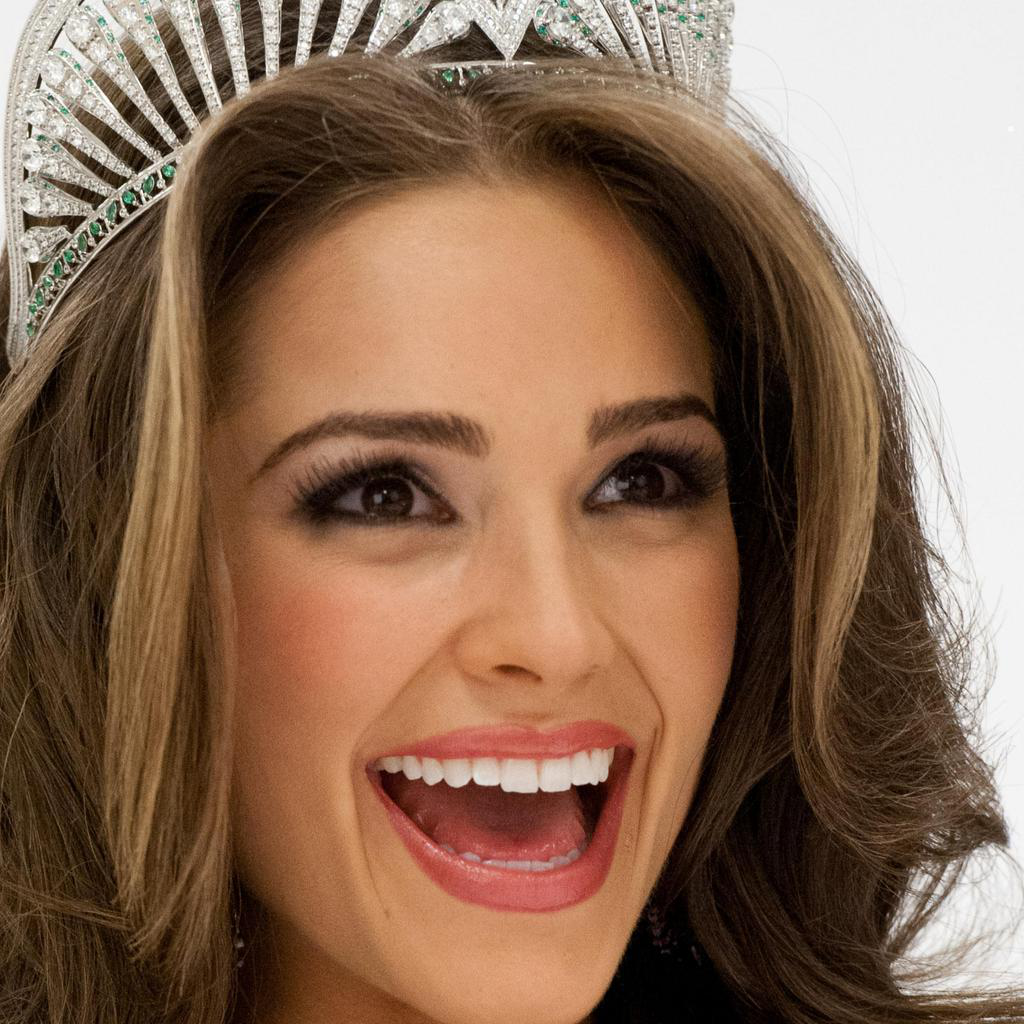

In [ ]:
import torch
import torchvision.transforms as transforms

T.ToPILImage()(torch.from_numpy(images[0]).permute(2, 0, 1))
# T.ToPILImage()(images[0].permute(2, 0, 1))

Finally we create our dataloader.

In [ ]:
dl = (
    wds.WebLoader(ds, batch_size=None, num_workers=2).unbatched().batched(total_bs)
)  # avoid partial batch at the end of each worker

## Image encoder

We'll use a VQGAN trained with Taming Transformers and converted to a JAX model.

In [ ]:
!pip install git+https://github.com/patil-suraj/vqgan-jax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/patil-suraj/vqgan-jax.git to /tmp/pip-req-build-uka7svhe
  Running command git clone --filter=blob:none --quiet https://github.com/patil-suraj/vqgan-jax.git /tmp/pip-req-build-uka7svhe
  Resolved https://github.com/patil-suraj/vqgan-jax.git to commit 10ef240f8ace869e437f3c32d14898f61512db12
  Preparing metadata (setup.py) ... done
  Created wheel for vqgan-jax: filename=vqgan_jax-0.0.1-py3-none-any.whl size=7798 sha256=30a307d7fcaf550104c6c81d423faa82db7e6a8734387aba81948c550588118a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8n04a0t4/wheels/d5/a7/0f/b27d5c93a98bf5b8ac2ecc2f9bbba9b52f6f25b84ac63693cb
Successfully built vqgan-jax


In [ ]:
from vqgan_jax.modeling_flax_vqgan import VQModel
from flax.jax_utils import replicate

vqgan = VQModel.from_pretrained("dalle-mini/vqgan_imagenet_f16_16384")
# vqgan = VQModel.from_pretrained("flax-community/vqgan_f16_16384")
# vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

vqgan_params = replicate(vqgan.params)

## Encoding

Encoding is really simple using `shard` to automatically distribute batches across devices and `pmap`.

In [ ]:
from flax.training.common_utils import shard
from functools import partial


@partial(jax.pmap, axis_name="batch")
def p_encode(batch, params):
    # Not sure if we should `replicate` params, does not seem to have any effect
    _, indices = vqgan.encode(batch, params=params)
    return indices

In [ ]:
import pandas as pd
import os.path


def encode_dataset(dataloader, output_dir, save_frequency):
    output_dir.mkdir(parents=True, exist_ok=True)
    all_captions = []
    all_encoding = []
    n_file = 0
    nfile = 0
    file_exists = os.path.exists(f"{output_dir}/{nfile}.parquet")

    for idx, (images, captions) in enumerate(tqdm(dataloader)):
        images = images.numpy()
        # n = len(images) // 8 * 8
        n = len(images)

        if n != len(images):
            # get the max number of images we can (multiple of 8)
            print(f"Different sizes {n} vs {len(images)}")
            images = images[:n]
            captions = captions[:n]
            n_file += 1
            file_exists = os.path.exists(f"{output_dir}/{nfile}.parquet")

        if not len(captions) or file_exists:
            print(f"No images/captions in batch...")
            continue
        images = shard(images)
        encoded = p_encode(images, vqgan_params)
        encoded = encoded.reshape(-1, encoded.shape[-1])
        all_captions.extend(captions)
        all_encoding.extend(encoded.tolist())

        # save files
        if (idx + 1) % save_frequency == 0:
            print(f"Saving file {n_file}")
            batch_df = pd.DataFrame.from_dict(
                {"caption": all_captions, "encoding": all_encoding}
            )
            batch_df.to_parquet(f"{output_dir}/{n_file:03d}.parquet")
            all_captions = []
            all_encoding = []
            n_file += 1

    if len(all_captions):
        print(f"Saving final file {n_file}")
        batch_df = pd.DataFrame.from_dict(
            {"caption": all_captions, "encoding": all_encoding}
        )
        batch_df.to_parquet(f"{output_dir}/{n_file:03d}.parquet")

In [ ]:
encode_dataset(dl, output_dir=encoded_output, save_frequency=save_frequency)

0it [00:00, ?it/s]

Saving file 0
Saving file 1
Saving file 2
Saving file 3
Saving file 4
Saving file 5
Saving file 6
Saving file 7
Saving file 8
Saving file 9
Saving file 10
Saving file 11
Saving file 12
Saving file 13
Saving file 14
Saving file 15
Saving file 16


----